# Experiment 5: Random Forest Hyperparameter Tuning

## Installing and importing packages

In [ ]:
%pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.2/258.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.3 MB/s eta 0:00:00


In [ ]:
import mlflow
import optuna

import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from data_cleaning_utils import clean_data

set_config(transform_output="pandas")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Connecting with dagshub and MLFlow

In [ ]:
import dagshub
dagshub.init(repo_owner='SushrutGaikwad', repo_name='swiggy-delivery-time-prediction', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=168c173e-2d85-415b-ad38-ae1c417e744d&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=12b09bb68c1e4c33aa1d57b50314d61557646cbeb6d2aff3c546609102121a98




Accessing as SushrutGaikwad

Initialized MLflow to track repo "SushrutGaikwad/swiggy-delivery-time-prediction"

Repository SushrutGaikwad/swiggy-delivery-time-prediction initialized!

In [ ]:
mlflow.set_tracking_uri("https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow")
mlflow.set_experiment("Exp 5: Random forest HP tuning")

## Loading and cleaning the data

In [ ]:
df = pd.read_csv("/content/swiggy.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [ ]:
df = clean_data(df=df)
df.head()

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,distance,distance_type,order_day,order_month,order_day_of_week,order_day_is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,3.025149,short,19,3,saturday,1,15.0,11.0,morning
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,20.183530,very_long,25,3,friday,0,5.0,19.0,evening
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,1.552758,short,19,3,saturday,1,15.0,8.0,morning
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,7.790401,medium,5,4,tuesday,0,10.0,18.0,evening
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,6.210138,medium,26,3,saturday,1,15.0,13.0,afternoon


## Dropping unnecessary columns

In [ ]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'distance', 'distance_type',
       'order_day', 'order_month', 'order_day_of_week', 'order_day_is_weekend',
       'pickup_time_minutes', 'order_time_hour', 'order_time_of_day'],
      dtype='object')

In [ ]:
cols_to_drop = [
    'rider_id',
    'restaurant_latitude',
    'restaurant_longitude',
    'delivery_latitude',
    'delivery_longitude',
    'order_date',
    'order_time_hour',
    'order_day',
    'city_name',
    'order_day_of_week',
    'order_month',
]

df.drop(columns=cols_to_drop, inplace=True)
df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


In [ ]:
df.shape

(45502, 16)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45502 entries, 0 to 45592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   43648 non-null  float64 
 1   ratings               43594 non-null  float64 
 2   weather               44977 non-null  object  
 3   traffic               44992 non-null  object  
 4   vehicle_condition     45502 non-null  int64   
 5   type_of_order         45502 non-null  object  
 6   type_of_vehicle       45502 non-null  object  
 7   multiple_deliveries   44509 non-null  float64 
 8   festival              45274 non-null  object  
 9   city_type             44304 non-null  object  
 10  time_taken            45502 non-null  int64   
 11  distance              41872 non-null  float64 
 12  distance_type         41872 non-null  category
 13  order_day_is_weekend  45502 non-null  int64   
 14  pickup_time_minutes   43862 non-null  float64 
 15  order_t

## Checking for duplicates

In [ ]:
df.duplicated().sum()

0

## Missing values

In [ ]:
df.isna().sum()

,0
age,1854
ratings,1908
weather,525
traffic,510
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,993
festival,228
city_type,1198


In [ ]:
df.isna().sum().sum()

17756

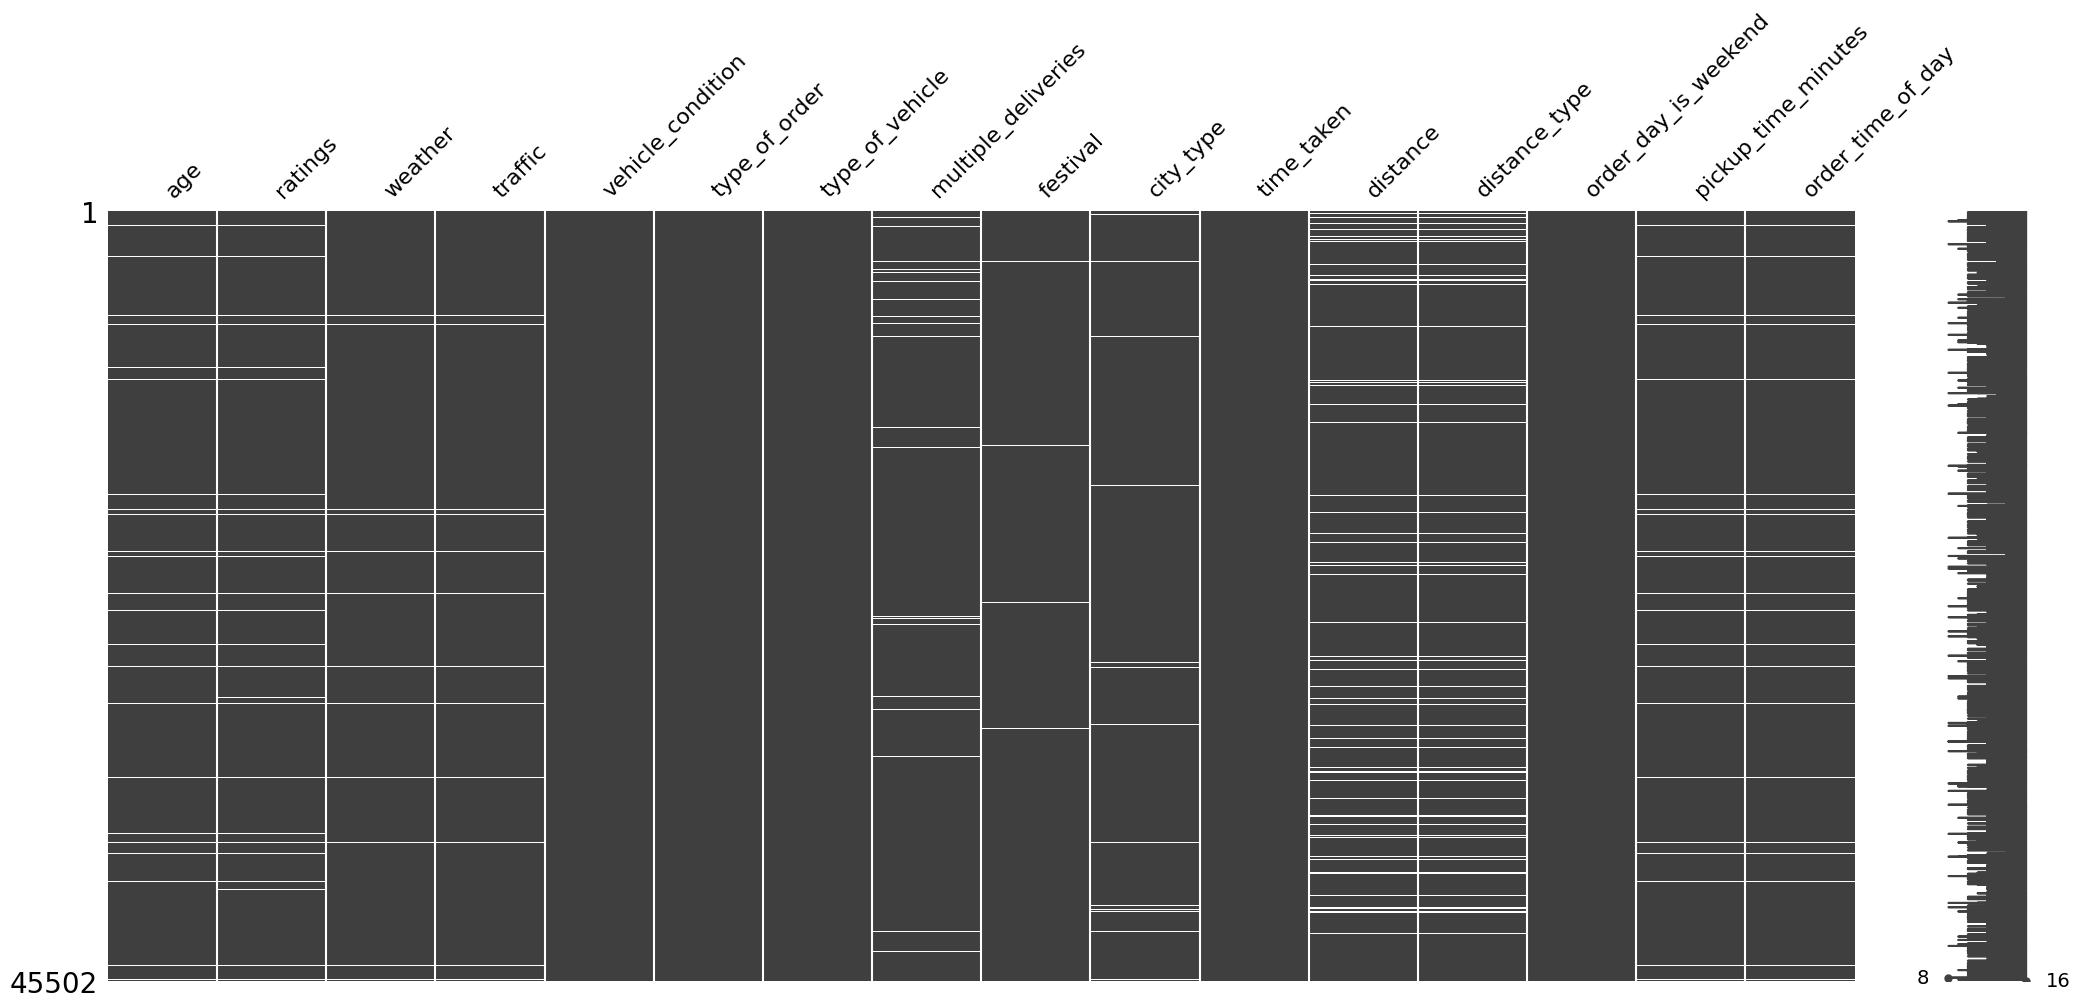

In [ ]:
msno.matrix(df);

In [ ]:
missing_cols = df.columns[df.isnull().any()]
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'distance', 'distance_type',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

## Dropping missing values

In [ ]:
temp_df = df.copy().dropna()
temp_df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


## Input-output split

In [ ]:
X = temp_df.drop(columns=['time_taken'])
y = temp_df['time_taken']

In [ ]:
X.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,6.210138,medium,1,15.0,afternoon


In [ ]:
y.head()

,time_taken
0,24
1,33
2,26
3,21
4,30


## Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

X_train.shape = (30451, 15)
X_test.shape = (7613, 15)


In [ ]:
X_train.isna().sum().sum()

0

## Types of columns

In [ ]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'distance', 'distance_type', 'order_day_is_weekend',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

In [ ]:
num_cols = ['age', 'ratings', 'pickup_time_minutes', 'distance']

nominal_cat_cols = [
    'weather',
    'type_of_order',
    'type_of_vehicle',
    'festival',
    'city_type',
    'order_day_is_weekend',
    'order_time_of_day',
]

ordinal_cat_cols = ['traffic', 'distance_type']

We did not consider the columns `multiple_deliveries` and `vehicle_condition` as these both are already encoded appropriately.

In [ ]:
len(X_train.columns)

15

In [ ]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

13

In [ ]:
for col in ordinal_cat_cols:
    print(f"{col}: {X_train[col].unique()}")

traffic: ['jam' 'low' 'medium' 'high']
distance_type: ['short', 'very_long', 'long', 'medium']
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


## Creating order for ordinal categorical columns

In [ ]:
traffic_order = ['low', 'medium', 'high', 'jam']
distance_type_order = ['short', 'medium', 'long', 'very_long']

## Building a preprocessor

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_cols),
        ("nominal_encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),
        ("ordinal_encoder", OrdinalEncoder(categories=[traffic_order, distance_type_order]), ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False,
)

preprocessor.set_output(transform='pandas')

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scaler', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type',
                                  'order_day_is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

## Transformer for the target

In [ ]:
pt = PowerTransformer(method="yeo-johnson")

y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))

## Preprocessing pipeline

In [ ]:
preprocessing_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
    ]
)

preprocessing_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  ['age', 'ratings',
                                                   'pickup_time_minutes',
                                                   'distance']),
                                                 ('nominal_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'order_day_is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']]),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False))])

## Transforming the input

In [ ]:
X_train_transformed = preprocessing_pipeline.fit_transform(X_train)
X_test_transformed = preprocessing_pipeline.transform(X_test)

In [ ]:
X_train_transformed.head()

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_urban,order_day_is_weekend_1,order_time_of_day_afternoon,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
24986,0.052632,0.80,0.5,0.163629,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1,0.0
9452,0.526316,0.96,1.0,0.157036,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,2,1.0
18442,0.631579,1.00,0.0,0.160160,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,2,2.0
15294,0.789474,0.96,0.5,0.003145,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.0
44012,0.157895,0.88,0.5,0.084651,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1.0


## Hyperparameter tuning of random forest

In [ ]:
def objective(trial):
    with mlflow.start_run(nested=True):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 10, 500),
            "max_depth": trial.suggest_int("max_depth", 1, 30),
            "max_features": trial.suggest_categorical("max_features", [None, "sqrt", "log2"]),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_samples": trial.suggest_float("max_samples", 0.5, 1),
            "random_state": 42,
            "n_jobs": -1,
        }

        # log model params
        mlflow.log_params(params)

        rf = RandomForestRegressor(**params)
        model = TransformedTargetRegressor(regressor=rf, transformer=pt)

        # training the model
        model.fit(X_train_transformed, y_train)

        # predictions
        y_pred_train = model.predict(X_train_transformed)
        y_pred_test = model.predict(X_test_transformed)

        # cross validation
        cv_score = cross_val_score(
            model,
            X_train_transformed,
            y_train,
            cv=5,
            scoring="neg_mean_absolute_error",
            n_jobs=-1,
        )

        # mean cv score
        mean_cv_score = -(cv_score.mean())

        # log mean cv score
        mlflow.log_metric("mean_cv_score", mean_cv_score)

        return mean_cv_score

In [ ]:
study = optuna.create_study(direction="minimize")

with mlflow.start_run(run_name="best_model"):
    # optimize the objective function
    study.optimize(objective, n_trials=20, n_jobs=-1, show_progress_bar=True)

    # log the best params
    mlflow.log_params(study.best_params)

    # log the best score
    mlflow.log_metric("best_score", study.best_value)

    # train the model on best params
    best_rf = RandomForestRegressor(**study.best_params)
    best_rf.fit(X_train_transformed, y_train_transformed.values.ravel())

    # predictions
    y_pred_train = best_rf.predict(X_train_transformed)
    y_pred_test = best_rf.predict(X_test_transformed)

    y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))

    # cross validation
    model = TransformedTargetRegressor(regressor=best_rf, transformer=pt)

    cv_scores = cross_val_score(
        model,
        X_train_transformed,
        y_train,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1,
    )

    # logging metrics
    mlflow.log_metric("training_mae", mean_absolute_error(y_train,y_pred_train))
    mlflow.log_metric("test_mae", mean_absolute_error(y_test,y_pred_test))
    mlflow.log_metric("training_r2", r2_score(y_train,y_pred_train))
    mlflow.log_metric("test_r2", r2_score(y_test,y_pred_test))
    mlflow.log_metric("cross_val", -(cv_scores.mean()))

    # log the best model
    mlflow.sklearn.log_model(best_rf, artifact_path="model")

[I 2025-01-12 17:17:49,601] A new study created in memory with name: no-name-9a5f25f2-de2f-4f9d-8c71-f330c785f678


  0%|          | 0/20 [00:00<?, ?it/s]

🏃 View run stately-rook-727 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9/runs/244d65157d9a4dc097cb9f258ca78b59
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9
[I 2025-01-12 17:18:01,243] Trial 1 finished with value: 5.061379963127277 and parameters: {'n_estimators': 113, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_samples': 0.7102504123635234}. Best is trial 1 with value: 5.061379963127277.
🏃 View run unique-fawn-258 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9/runs/0eaea39eda99440087a7d41b5e570724
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9
[I 2025-01-12 17:20:19,163] Trial 0 finished with value: 3.080441511588794 and parameters: {'n_estimators': 226, 'max_depth': 15, 'max_features': None, 'min_samples_split': 4

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


🏃 View run unique-hound-957 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9/runs/db77952e1c64449bac971adcd99a917c
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9
[I 2025-01-12 17:32:26,359] Trial 11 finished with value: 3.1463802364402533 and parameters: {'n_estimators': 490, 'max_depth': 22, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_samples': 0.8650451845236602}. Best is trial 2 with value: 3.0715613710863616.
🏃 View run gaudy-crane-728 at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9/runs/3bb8cedc256747eaa6c559da1e454900
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9
[I 2025-01-12 17:32:31,376] Trial 12 finished with value: 3.072383778436082 and parameters: {'n_estimators': 215, 'max_depth': 30, 'max_features': None, 'min_samples_spli

2025/01/12 17:44:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run best_model at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9/runs/25af8230c51243349f809d3645d0aa26
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/9


In [ ]:
study.best_params

{'n_estimators': 158,
 'max_depth': 19,
 'max_features': None,
 'min_samples_split': 8,
 'min_samples_leaf': 6,
 'max_samples': 0.6205450829340415}

In [ ]:
study.best_value

3.0690016428414495

In [ ]:
# optimization history plot

optuna.visualization.plot_optimization_history(study)

In [ ]:
# plot hyperparameter importance plot

optuna.visualization.plot_param_importances(study)

In [ ]:
# slice plot

optuna.visualization.plot_slice(study)